#A non-trivial example
---

We will open a .nc file, read some data, perform some operations on the data,
and do plot 1/2-d statistics.

For this we will need the netcdf library installed (most of you should have it installed)
and the netCDF4 python module installed. netCDF4 depends on both the **netCDF and MPI** libraries,
so these have to be installed separately (or just use **apt-get**!). Installation should simply
then be
    
    sudo pip install netCDF4
    
or
    
    sudo apt-get install python-netcdf4

In [7]:
#Ask plots to work inline
%pylab inline

import netCDF4

Populating the interactive namespace from numpy and matplotlib


If you don't want plots to appear within the notebook, then comment the
first line.

We then create a Dataset object based on an netcdf file


In [8]:
ncfile = netCDF4.Dataset('/data/MonthlyFields/uWinds.nc')
print ncfile

<type 'netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format UNDEFINED):
    Conventions: CF-1.0
    history: 2015-01-23 03:06:51 GMT by grib_to_netcdf-1.12.3: grib_to_netcdf /data/data01/netcdf-web221-20150123030414-21936-4167.target -o /data/data01/netcdf-web221-20150123030641-21936-4168.nc
    dimensions(sizes): longitude(480), latitude(241), level(6), time(432)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 level(level), int32 time(time), int16 u(time,level,latitude,longitude)
    groups: 



In [116]:
print ncfile.variables.keys()

[u'longitude', u'latitude', u'level', u'time', u'u']


In [10]:
print ncfile.dimensions

OrderedDict([(u'longitude', <type 'netCDF4.Dimension'>: name = 'longitude', size = 480
), (u'latitude', <type 'netCDF4.Dimension'>: name = 'latitude', size = 241
), (u'level', <type 'netCDF4.Dimension'>: name = 'level', size = 6
), (u'time', <type 'netCDF4.Dimension'>: name = 'time', size = 432
)])


since **ncfiles.variables** is a dict, we can access its members using
the keys returned by **ncfiles.variables.keys()**

In [11]:
print ncfile.variables['time']

<type 'netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:0.0
    long_name: time
unlimited dimensions: 
current shape = (432,)
filling off



The values can be accessed just like any numpy array

In [12]:
print ncfile.variables['time'][0:10]

[692496 693240 693912 694656 695376 696120 696840 697584 698328 699048]


In [13]:
print ncfile.variables['u'].shape

(432, 6, 241, 480)


For convenience, we can assign this long thing into another variable

In [14]:
uWinds = ncfile.variables['u']
print uWinds.shape

(432, 6, 241, 480)


In [15]:
lats = ncfile.variables['latitude'][:]
lons = ncfile.variables['longitude'][:]
print lats

[ 90.    89.25  88.5   87.75  87.    86.25  85.5   84.75  84.    83.25
  82.5   81.75  81.    80.25  79.5   78.75  78.    77.25  76.5   75.75  75.
  74.25  73.5   72.75  72.    71.25  70.5   69.75  69.    68.25  67.5
  66.75  66.    65.25  64.5   63.75  63.    62.25  61.5   60.75  60.    59.25
  58.5   57.75  57.    56.25  55.5   54.75  54.    53.25  52.5   51.75  51.
  50.25  49.5   48.75  48.    47.25  46.5   45.75  45.    44.25  43.5
  42.75  42.    41.25  40.5   39.75  39.    38.25  37.5   36.75  36.    35.25
  34.5   33.75  33.    32.25  31.5   30.75  30.    29.25  28.5   27.75  27.
  26.25  25.5   24.75  24.    23.25  22.5   21.75  21.    20.25  19.5
  18.75  18.    17.25  16.5   15.75  15.    14.25  13.5   12.75  12.    11.25
  10.5    9.75   9.     8.25   7.5    6.75   6.     5.25   4.5    3.75   3.
   2.25   1.5    0.75   0.    -0.75  -1.5   -2.25  -3.    -3.75  -4.5
  -5.25  -6.    -6.75  -7.5   -8.25  -9.    -9.75 -10.5  -11.25 -12.   -12.75
 -13.5  -14.25 -15.   -15.75 -16.

In [16]:
southernHemisphereWinds = uWinds[:,:,lats<0,:]
northernHemisphereWinds = uWinds[:,:,lats>0,:]

In [17]:
print southernHemisphereWinds.shape, northernHemisphereWinds.shape

(432, 6, 120, 480) (432, 6, 120, 480)


We can also try choosing a particular area. Let us choose between 40 - 100 degrees east and 0 and 40 degrees north

In [18]:
chosenLons = np.logical_and(lons>40, lons<100)
chosenLats = np.logical_and(lats>0, lats<40)

chosenArea = uWinds[:,:,chosenLats,chosenLons]
print chosenArea.shape

(432, 6, 53, 80)


#Easy, easy documentation!
---

Python makes it very simple to document your code, and for others to read that documentation.
Comments in **triple quotes** are special in Python. Let us write a function that calculates
the area weighted average:

$A = \int_0^{360}\int_{-90}^{90} f(\lambda,\theta)\cos\theta d\lambda d\theta$

where $\lambda, \theta$ are longitude and latitude respectively

In [127]:
def calculateAreaWeightedAverage(field, latitudes):
    """ Calculate the area weighted average of a given field.
    
    :param field: The data to be averaged, in (lats, lons) format.
    :type field: float
    
    :param latitudes: The number of latitudes available in the data.
        It must have the same length at field[:,0]
    :type field: float
    
    :returns avg: The averaged value
    :rtype: float
    """
    
    weights = np.cos(np.radians(latitudes))
    weights = weights[:,np.newaxis]
    
    field = field*weights
    
    averageValue = np.mean(field)
    return averageValue

We can easily check how to use the function by typing a question mark:

In [126]:
?calculateAreaWeightedAverage

##Back to our example...

We can also convert to and from index and dates by using some helper
functions netCDF4 provides us:

In [129]:
from netCDF4 import num2date, date2num, datetime

timeValues = ncfile.variables['time']
print num2date(timeValues[23], timeValues.units)

startDate = datetime(2001,1,1)
endDate = datetime(2010,1,1)

startIndex = date2num(startDate, timeValues.units)
endIndex = date2num(endDate, timeValues.units)

print startIndex, endIndex

print list(startIndex == timeValues[:]).index(True)
print list(endIndex == timeValues[:]).index(True)


1980-12-01 00:00:00
885360.0 964248.0
264
372


##Calculating means

numpy has both *mean()* and *average()* functions. *average()* takes
an optional set of weights, as seen in the previous example.

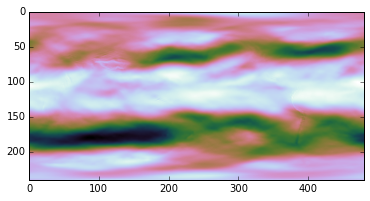

In [79]:
# Choose a random map from our data set

windsOnSomeDay = uWinds[20,4,:]
imshow(windsOnSomeDay, cmap='cubehelix_r')

<matplotlib.colorbar.Colorbar instance at 0x7f3236439290>

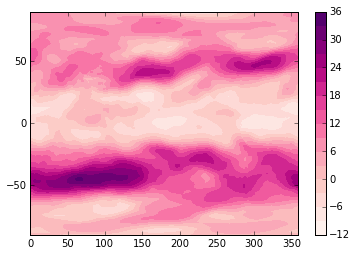

In [134]:
# Or use contour plots

x,y = np.meshgrid(lons, lats)
contourf(x,y,windsOnSomeDay, 16, cmap='RdPu')
colorbar()

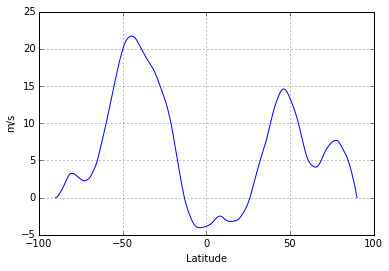

In [80]:
#Zonal mean

zonalAvg = np.mean(windsOnSomeDay, axis=1)
plot(lats, zonalAvg)
grid()
xlabel('Latitude')
ylabel('m/s')

In [81]:
print calculateAreaWeightedAverage(windsOnSomeDay, lats)

0.00302803804773


In [83]:
print np.mean(zonalAvg*np.cos(lats))

0.00302803804773


We can also easily mask some values that we don't want to be plotted...

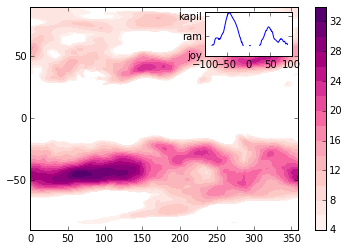

In [147]:
#Create mask

maskedArray = np.ma.array(windsOnSomeDay, mask=windsOnSomeDay<5)

zonalAvg2 = np.ma.mean(maskedArray, axis=1)

contourf(x,y,maskedArray, 16, cmap='RdPu')
colorbar()

fig = gcf()
ax = fig.add_axes((0.53,0.73,0.2,0.15),axis_bgcolor='white')
ax.plot(lats, zonalAvg2)
ax.set_yticks((0, 10, 20))
ax.yaxis.set_ticklabels(['joy','ram','kapil'])

In [140]:
maskedArray.mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

<matplotlib.colorbar.Colorbar instance at 0x7f3235261440>

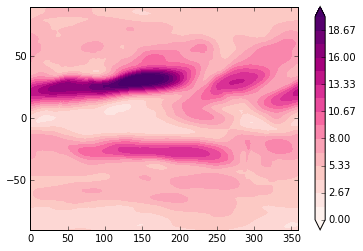

In [148]:
windsAtOneLevel = uWinds[:,3,:]

windVariability = np.std(windsAtOneLevel, axis=0)

contourf(x,y,windVariability, linspace(0,20,16), extend='both', cmap='RdPu')
colorbar()


$I = \int_0^p f(p) dp$

$I = \int_0^L f(p)dp$